Importation du modèle VCC-16


In [1]:
import os
%cd
from keras.applications.vgg16 import VGG16

model = VGG16( include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              classifier_activation='softmax'
             ) # Création du modèle VGG-16 implementé par Keras


/home/fedecabre


/home/fedecabre


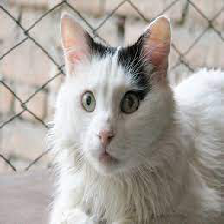

In [2]:
%cd
# à la racine pour avoir accès aux datas
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

project_path ='Documents/OC_Ingenieur_ML/P6_Classez_des_images/'
img = load_img(project_path+'data/cat.jpeg', target_size=(224, 224))  # Charger l'image
display(img)
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [5]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n02124075', 'Egyptian_cat', 0.25156984), ('n02127052', 'lynx', 0.19743551), ('n01877812', 'wallaby', 0.16383485)]


# Transfert Learning


In [7]:
!ls



 anaconda3			    java_error_in_pycharm_2289.log
'Bibliothèque calibre'		    java_error_in_pycharm_3290.log
 cuda_11.3.0_465.19.01_linux.run    keras
 Desktop			    nltk_data
 Documents			    NVIDIA_CUDA-11.3_Samples
 GDrive				    scikit_learn_data
 Images				    seaborn-data
 java_error_in_pycharm_102792.log   snap
 java_error_in_pycharm_2254.log     Téléchargements


Features (train_data.mat, test_data.mat):
 - train_data/test_data
   -- contains the feature matrix after histogram intersection kernel has been applied
 - train_fg_data/test_fg_data
   -- contains the feature matrix before applying the histogram intersection kernel
 - train_info/test_info
   -- contains the labels and ids for the corresponding image in the feature matrix

In [9]:
import os
import numpy as np
import imageio
from xml.dom import minidom
from PIL import Image

def make_dataset_race(folder,image_size=224, num_channels = 3):
    image_files=os.listdir(project_path+folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = project_path+folder+'/'+image
        image_data = imageio.imread(image_file)
        annon_file = project_path+'data/Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
        annon_xml = minidom.parse(annon_file)
        xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
        ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
        xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
        ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)

        new_image_data = image_data[ymin:ymax,xmin:xmax,:]
        new_image = Image.fromarray(new_image_data)
        new_image = new_image.resize(size=(image_size,image_size))
        crop_dir = project_path+'data/Cropped/'+ folder.split('/')[-1]
        if os.path.exists(project_path+'data/Cropped/') is False:
            os.mkdir(project_path+'data/Cropped/')
        if os.path.exists(crop_dir) is False:
            os.mkdir(crop_dir)
        #new_image.save(crop_dir+'/'+image)
        dataset[num_images, :, :, :] = np.array(new_image)
        num_images = num_images + 1
    dataset = dataset[0:num_images, :, :, :]
    print('Full dataset tensor:', dataset.shape)
    return dataset

folder = 'data/Images/n02085620-Chihuahua'
dataset_chien = make_dataset_race(folder)

Full dataset tensor: (152, 224, 224, 3)


In [10]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows,img_size, img_size,num_channels), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [11]:
images_folders_path = "data/Images/"
images_folders=os.listdir(project_path+images_folders_path)

num_classes = 10 # len(images_folders)
train_size = 1000
valid_size=500
image_size=224
num_channels = 3

# Création des datasets vides
valid_dataset, valid_labels = make_arrays(valid_size, image_size)
train_dataset, train_labels = make_arrays(train_size, image_size)


vsize_per_class = valid_size // num_classes
tsize_per_class = train_size // num_classes

start_v, start_t = 0, 0
end_v, end_t = vsize_per_class, tsize_per_class
end_l = vsize_per_class+tsize_per_class

for label,folder in enumerate(images_folders):
    if label < num_classes :
        dataset_race = make_dataset_race('data/Images/'+folder)
        train_breed = dataset_race[vsize_per_class:end_l, :, :, :]
        train_dataset[start_t:end_t, :, :, :] = train_breed
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
        if valid_dataset is not None:
            valid_breed = dataset_race[:vsize_per_class, :, :, :]
            valid_dataset[start_v:end_v, :, :, :] = valid_breed
            valid_labels[start_v:end_v] = label
            start_v += vsize_per_class
            end_v += vsize_per_class


Full dataset tensor: (182, 224, 224, 3)
Full dataset tensor: (153, 224, 224, 3)
Full dataset tensor: (168, 224, 224, 3)
Full dataset tensor: (156, 224, 224, 3)
Full dataset tensor: (210, 224, 224, 3)
Full dataset tensor: (150, 224, 224, 3)
Full dataset tensor: (157, 224, 224, 3)
Full dataset tensor: (151, 224, 224, 3)
Full dataset tensor: (150, 224, 224, 3)
Full dataset tensor: (159, 224, 224, 3)


In [12]:
print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)

(1000, 224, 224, 3)
(1000,)
(500, 224, 224, 3)
(500,)


In [13]:
#train_labels_one_hot = np.zeros((train_labels.size, train_labels.max()+1))
#train_labels_one_hot[np.arange((train_labels.size),train_labels)]=1
#train_labels_one_hot.shape

from keras.utils.np_utils import to_categorical

train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
valid_labels_categorical = to_categorical(valid_labels, num_classes=num_classes)
print(train_labels_categorical.shape)
print(valid_labels_categorical.shape)

(1000, 10)
(500, 10)


# Modèle VCC-16

## Stratégie fine tunning partiel

In [45]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
F = Flatten()(x)
DL1 = Dense(30)(F)
DL2 = Dense(30)(DL1)
predictions = Dense(10, activation='softmax')(DL2)

# Stratégie #2 : extraction de features
for layer in model.layers:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


Entraînement du modèle


In [46]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])

new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [47]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(train_dataset,
                           train_labels_categorical,
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset,valid_labels_categorical)
                           )

Epoch 1/15
32/32 [==============================] - 11s 343ms/step - loss: 29.2631 - accuracy: 0.6530 - val_loss: 11.1838 - val_accuracy: 0.8540
Epoch 2/15
32/32 [==============================] - 11s 335ms/step - loss: 3.4382 - accuracy: 0.9430 - val_loss: 9.4013 - val_accuracy: 0.8740
Epoch 3/15
32/32 [==============================] - 11s 337ms/step - loss: 0.5799 - accuracy: 0.9840 - val_loss: 9.1148 - val_accuracy: 0.8740
Epoch 4/15
32/32 [==============================] - 11s 350ms/step - loss: 0.4703 - accuracy: 0.9890 - val_loss: 7.3848 - val_accuracy: 0.8900
Epoch 5/15
32/32 [==============================] - 11s 349ms/step - loss: 0.2549 - accuracy: 0.9890 - val_loss: 11.3104 - val_accuracy: 0.8700
Epoch 6/15
32/32 [==============================] - 11s 350ms/step - loss: 0.2491 - accuracy: 0.9920 - val_loss: 9.3757 - val_accuracy: 0.8900
Epoch 7/15
32/32 [==============================] - 11s 357ms/step - loss: 0.4272 - accuracy: 0.9880 - val_loss: 9.5552 - val_accuracy: 0.8

In [48]:
import matplotlib.pyplot as plt

def plot_loss(model_info,loss_min):
    loss = model_info.history['loss']
    val_loss = model_info.history['val_loss']

    epochs = range(1, len(loss) + 1)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.axvline(x=loss_min,color='red',linestyle='--')

    plt.show()

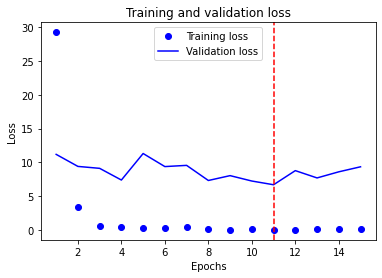

In [52]:
plot_loss(model_info,loss_min=11)

In [50]:
plt.clf()   # clear figure

def plot_accuracy(model_info,acc_max):
    acc_train = model_info.history['accuracy']
    acc_val = model_info.history['val_accuracy']

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, acc_train, 'bo', label='Training acc')
    plt.plot(epochs, acc_val, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.axvline(x=acc_max,color='red',linestyle='--')

    plt.show()

<Figure size 432x288 with 0 Axes>

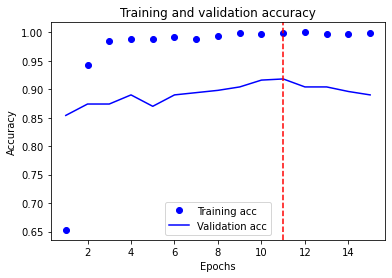

In [53]:
plot_accuracy(model_info,acc_max=11)

## Stratégie extraction des features

In [23]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(10, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [22]:
model.layers[:-1]

In [24]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])

new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [44]:
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model_info = new_model.fit(train_dataset,
                           train_labels_categorical,
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset,valid_labels_categorical)
                           )

Epoch 1/15
32/32 [==============================] - 11s 339ms/step - loss: 0.3249 - accuracy: 0.8980 - val_loss: 0.4944 - val_accuracy: 0.8460
Epoch 2/15
32/32 [==============================] - 11s 338ms/step - loss: 0.3210 - accuracy: 0.8980 - val_loss: 0.4913 - val_accuracy: 0.8460
Epoch 3/15
32/32 [==============================] - 11s 339ms/step - loss: 0.3172 - accuracy: 0.8980 - val_loss: 0.4884 - val_accuracy: 0.8460
Epoch 4/15
32/32 [==============================] - 11s 340ms/step - loss: 0.3136 - accuracy: 0.8980 - val_loss: 0.4856 - val_accuracy: 0.8460
Epoch 5/15
32/32 [==============================] - 11s 341ms/step - loss: 0.3100 - accuracy: 0.8980 - val_loss: 0.4828 - val_accuracy: 0.8460
Epoch 6/15
32/32 [==============================] - 11s 341ms/step - loss: 0.3066 - accuracy: 0.8980 - val_loss: 0.4802 - val_accuracy: 0.8460
Epoch 7/15
32/32 [==============================] - 11s 342ms/step - loss: 0.3031 - accuracy: 0.8980 - val_loss: 0.4777 - val_accuracy: 0.8460

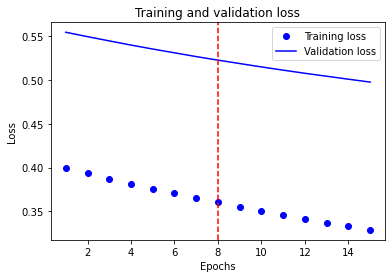

In [42]:
plot_loss(model_info,loss_min=8)

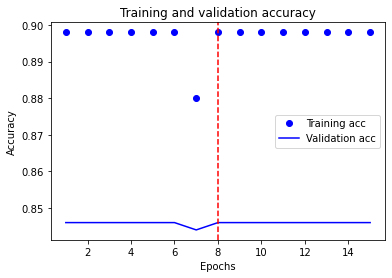

In [43]:
plot_accuracy(model_info,acc_max=8)